In [ ]:
from google.colab import files
uploaded = files.upload()
df

Saving Manhattan.csv to Manhattan.csv


Feature Information Gain Ranking:
                  Information Gain
price                     0.267930
minimum_nights            0.048664
availability_365          0.011107
------------------------------


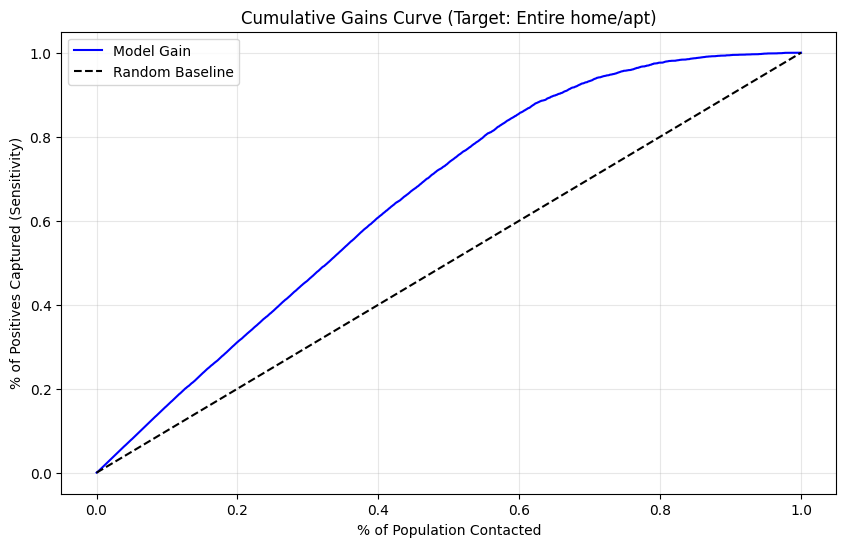

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

# 1. Load the dataset
df = pd.read_csv('Manhattan.csv')

# Define Features and Target
# We want to classify 'room_type'
X = df[['price', 'minimum_nights', 'availability_365']]
y = df['room_type']

# ---------------------------------------------------------
# Part A: Calculate Information Gain (Feature Importance)
# ---------------------------------------------------------

# Encode the target variable for calculation
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Calculate Mutual Information (Information Gain)
ig = mutual_info_classif(X, y_encoded, discrete_features=False, random_state=42)

# Create a summary dataframe
ig_df = pd.DataFrame(ig, index=X.columns, columns=['Information Gain'])
ig_df = ig_df.sort_values(by='Information Gain', ascending=False)

print("Feature Information Gain Ranking:")
print(ig_df)
print("-" * 30)

# ---------------------------------------------------------
# Part B: Generate Cumulative Gains Curve
# ---------------------------------------------------------

# Treat "Entire home/apt" as the positive class (1) and others as (0)
y_binary = (y == 'Entire home/apt').astype(int)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.3, random_state=42)

# Train a Decision Tree Classifier (uses Information Gain internally)
clf = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)
clf.fit(X_train, y_train)

# Get predicted probabilities for the positive class
y_prob = clf.predict_proba(X_test)[:, 1]

# Create a DataFrame with actual outcome and predicted probability
results = pd.DataFrame({'actual': y_test, 'prob': y_prob})
results = results.sort_values(by='prob', ascending=False)

# Calculate Cumulative Gain
total_positives = results['actual'].sum()
results['cum_positives'] = results['actual'].cumsum()
results['gain'] = results['cum_positives'] / total_positives
results['percent_population'] = np.arange(1, len(results) + 1) / len(results)

# Plot the Gains Curve
plt.figure(figsize=(10, 6))
plt.plot(results['percent_population'], results['gain'], label='Model Gain', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Baseline')
plt.xlabel('% of Population Contacted')
plt.ylabel('% of Positives Captured (Sensitivity)')
plt.title('Cumulative Gains Curve (Target: Entire home/apt)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('cumulative_gain_curve.png')
plt.show()

Feature Importance (Regression Gain):
                   Information Gain
room_type_encoded          0.260873
minimum_nights             0.078898
availability_365           0.075177
------------------------------


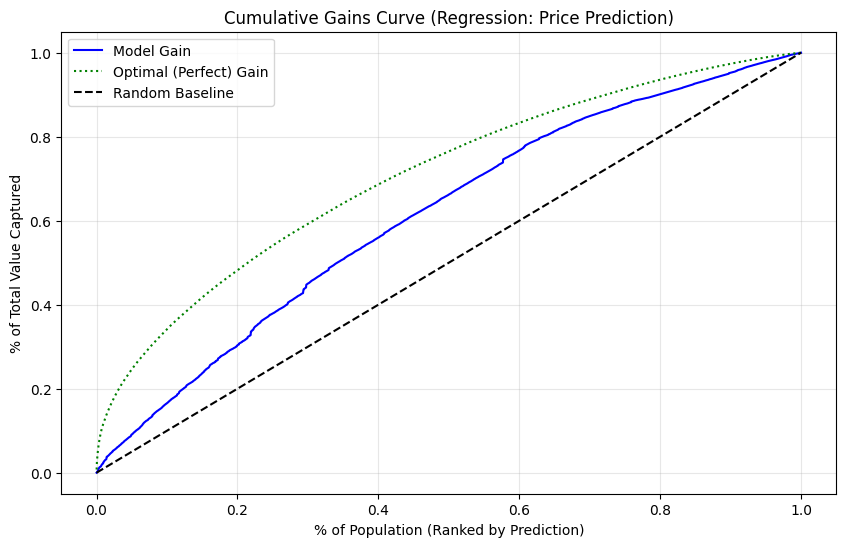

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder

# 1. Load Data
df = pd.read_csv('Manhattan.csv')

# 2. Prepare Data (Target: Price)
# Encode categorical 'room_type' for the model
le = LabelEncoder()
df['room_type_encoded'] = le.fit_transform(df['room_type'])

X = df[['room_type_encoded', 'minimum_nights', 'availability_365']]
y = df['price']

# ---------------------------------------------------------
# Part A: Feature Information Gain (Regression)
# ---------------------------------------------------------
# Calculate Mutual Information for continuous target
mi = mutual_info_regression(X, y, discrete_features='auto', random_state=42)
mi_df = pd.DataFrame(mi, index=X.columns, columns=['Information Gain'])
mi_df = mi_df.sort_values(by='Information Gain', ascending=False)

print("Feature Importance (Regression Gain):")
print(mi_df)
print("-" * 30)

# ---------------------------------------------------------
# Part B: Cumulative Gains Curve (Regression / Lift)
# ---------------------------------------------------------

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)

# Predict Prices
y_pred = rf.predict(X_test)

# Create a DataFrame to analyze ranking performance
results = pd.DataFrame({'actual': y_test, 'predicted': y_pred})

# Sort by PREDICTED price (Model's Ranking)
results = results.sort_values(by='predicted', ascending=False)

# Calculate Cumulative Gain
results['cum_actual_value'] = results['actual'].cumsum()
total_value = results['actual'].sum()
results['gain'] = results['cum_actual_value'] / total_value
results['percent_population'] = np.arange(1, len(results) + 1) / len(results)

# Calculate Optimal Gain (for comparison)
# What if we had sorted by ACTUAL price?
results_perfect = results.sort_values(by='actual', ascending=False)
optimal_gain = results_perfect['actual'].cumsum() / total_value

# Plot
plt.figure(figsize=(10, 6))
plt.plot(results['percent_population'], results['gain'], label='Model Gain', color='blue')
plt.plot(results['percent_population'], optimal_gain.values, label='Optimal (Perfect) Gain', color='green', linestyle=':')
plt.plot([0, 1], [0, 1], 'k--', label='Random Baseline')
plt.xlabel('% of Population (Ranked by Prediction)')
plt.ylabel('% of Total Value Captured')
plt.title('Cumulative Gains Curve (Regression: Price Prediction)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('regression_gain_curve.png')
plt.show()

In [ ]:
import heapq

def solve_chocolate_problem(n, edges, source, target, k):
    """
    n: Total number of nodes (labeled 1 to n)
    edges: List of [u, v, w]
    source: Starting node
    target: Ending node
    k: Max edges allowed to set to 0
    """

    # 1. Build Adjacency List
    adj = {i: [] for i in range(1, n + 1)}
    for u, v, w in edges:
        adj[u].append((v, w))

    # 2. Initialize Distances
    # dist[node][used_k] stores min cost to reach 'node' using exactly 'used_k' skips
    # Initialize with infinity
    inf = float('inf')
    dist = [[inf] * (k + 1) for _ in range(n + 1)]

    # 3. Priority Queue: (current_cost, current_node, skips_used)
    pq = [(0, source, 0)]
    dist[source][0] = 0

    while pq:
        d, u, used = heapq.heappop(pq)

        # Optimization: If we found a longer path than already known, skip
        if d > dist[u][used]:
            continue

        # If we reached target, we can theoretically stop here for simple Dijkstra,
        # but let's let it run to fill the table or return immediately.
        if u == target:
            return d

        for v, weight in adj[u]:
            # Option 1: Don't use a skip (Normal weight)
            if dist[u][used] + weight < dist[v][used]:
                dist[v][used] = dist[u][used] + weight
                heapq.heappush(pq, (dist[v][used], v, used))

            # Option 2: Use a skip (Weight becomes 0)
            # Only if we have skips remaining (used < k)
            if used < k:
                if dist[u][used] + 0 < dist[v][used + 1]:
                    dist[v][used + 1] = dist[u][used] + 0
                    heapq.heappush(pq, (dist[v][used + 1], v, used + 1))

    # The answer is the minimum cost to reach target using anywhere from 0 to k skips
    answer = min(dist[target])
    return answer if answer != inf else -1

# --- Testing with the Example in the Image ---
# Graph edges: (u, v, weight)
edges = [
    (1, 2, 3),
    (2, 4, 4),
    (1, 3, 10),
    (3, 4, 1)
]
n_nodes = 4
src = 1
tgt = 4

print(f"k=0 Answer: {solve_chocolate_problem(n_nodes, edges, src, tgt, 0)}") # Expected: 7
print(f"k=1 Answer: {solve_chocolate_problem(n_nodes, edges, src, tgt, 1)}") # Expected: 1
print(f"k=2 Answer: {solve_chocolate_problem(n_nodes, edges, src, tgt, 2)}") # Expected: 0

k=0 Answer: 7
k=1 Answer: 1
k=2 Answer: 0


FileNotFoundError: [Errno 2] No such file or directory: 'Manhattan.csv'

In [5]:
from google.colab import files
uploaded = files.upload()

KeyboardInterrupt: 

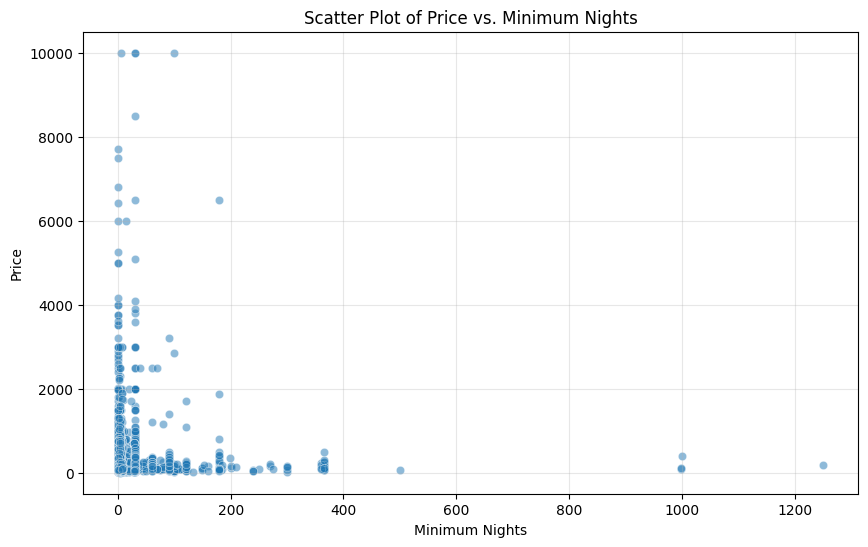

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the dataset within this cell
df = pd.read_csv('Manhattan.csv')

plt.figure(figsize=(10, 6))
sns.scatterplot(x='minimum_nights', y='price', data=df, alpha=0.5)
plt.title('Scatter Plot of Price vs. Minimum Nights')
plt.xlabel('Minimum Nights')
plt.ylabel('Price')
plt.grid(True, alpha=0.3)
plt.show()

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# 1. Load the dataset
df = pd.read_csv('Manhattan.csv')

# 2. Data Preprocessing
# Create a binary target variable: 'is_high_price'
# We'll define "High Price" as being above the median price (150)
median_price = df['price'].median()
df['is_high_price'] = (df['price'] > median_price).astype(int)

# Select features
# We need to convert categorical 'room_type' into numerical values (One-Hot Encoding)
# 'neighbourhood_group' is dropped because it only contains "Manhattan"
features = ['minimum_nights', 'availability_365']
X = df[features]
X = pd.concat([X, pd.get_dummies(df['room_type'], drop_first=True)], axis=1)

# Target variable
y = df['is_high_price']

# 3. Split the data into Training and Testing sets (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Feature Scaling (Important for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Initialize and Train Logistic Regression Model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# 6. Make Predictions
y_pred = model.predict(X_test_scaled)

# 7. Evaluate the Model
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Optional: View coefficients to see which features matter most
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_[0]})
print("\nFeature Coefficients:\n", coef_df.sort_values(by='Coefficient', ascending=False))

Model Accuracy: 0.7447495961227787

Confusion Matrix:
 [[1452  885]
 [ 221 1775]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.62      0.72      2337
           1       0.67      0.89      0.76      1996

    accuracy                           0.74      4333
   macro avg       0.77      0.76      0.74      4333
weighted avg       0.78      0.74      0.74      4333


Feature Coefficients:
             Feature  Coefficient
1  availability_365     0.451583
0    minimum_nights    -0.271892
3       Shared room    -0.473970
2      Private room    -1.340050


/tmp/ipython-input-1405121748.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_price, x='room_type', y='price', palette='viridis')
/tmp/ipython-input-1405121748.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df, x='Coefficient', y='Feature', palette='coolwarm')


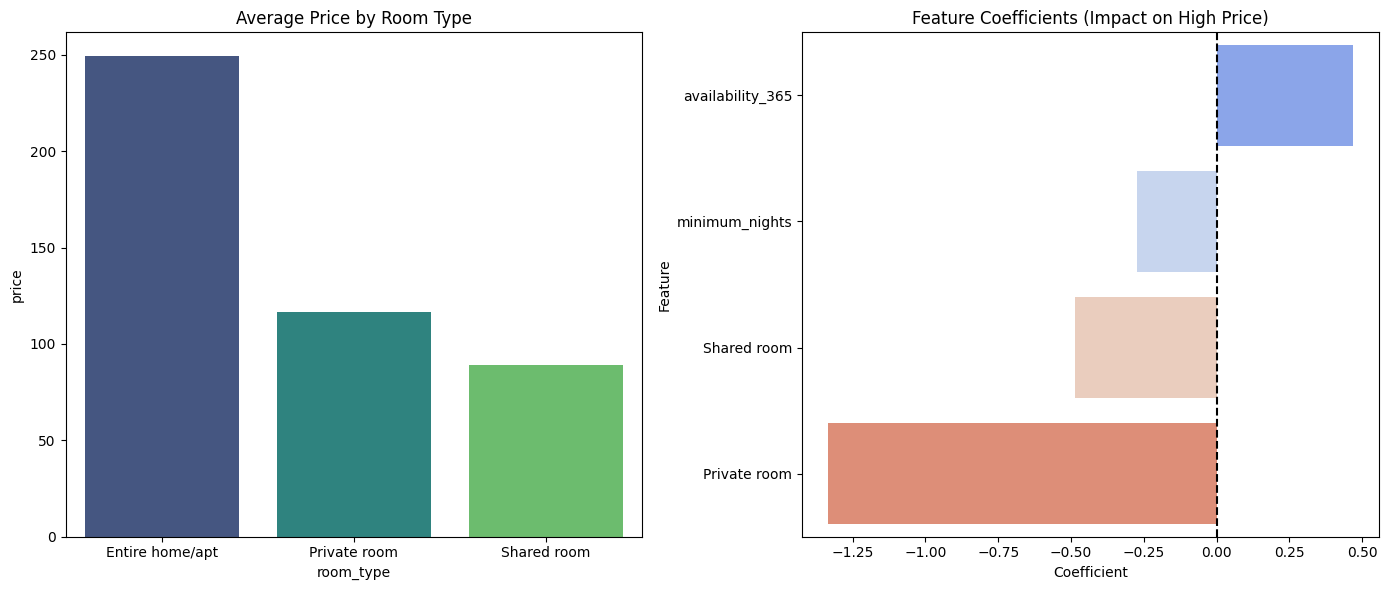

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Load Data
df = pd.read_csv('Manhattan.csv')

# --- Plot 1: Average Price ---
avg_price = df.groupby('room_type')['price'].mean().reset_index()

# --- Plot 2: Coefficients ---
# Re-run the regression logic to get coefficients
df['is_high_price'] = (df['price'] > df['price'].median()).astype(int)
X = pd.concat([df[['minimum_nights', 'availability_365']],
               pd.get_dummies(df['room_type'], drop_first=True)], axis=1)
y = df['is_high_price']

# Standardize features for comparable coefficients
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
model = LogisticRegression().fit(X_scaled, y)

# Create DataFrame for plotting
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_[0]})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

# --- Draw Plots ---
plt.figure(figsize=(14, 6))

# Subplot 1
plt.subplot(1, 2, 1)
sns.barplot(data=avg_price, x='room_type', y='price', palette='viridis')
plt.title('Average Price by Room Type')

# Subplot 2
plt.subplot(1, 2, 2)
sns.barplot(data=coef_df, x='Coefficient', y='Feature', palette='coolwarm')
plt.title('Feature Coefficients (Impact on High Price)')
plt.axvline(0, color='black', linestyle='--')

plt.tight_layout()
plt.show()